# Grid Search via Generated CUDA Code

In [1]:
import sys
sys.path.append('../../../neural/neural')

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pycuda
import pycuda.autoinit

from basemodel import Model

### Define An Arbitrary Model

First, we define an arbitrary model, called `FOO`, with one state variable $x$ and two parameters $a$ and $b4. The dynamic of the model is given below,

<p align="center">$\frac{dx}{dt} = 2a(1+u)^2 - exp(b^{1.2}u^{1.2})$,</p>

where $u$ is the input stimulus.

In [2]:
class FOO(Model):
    Default_States = {'x': 0.}
    Default_Params = {'a': 2., 'b': 2.} 
    
    def ode(self, stimulus=0):
        self.d_x = self.a*2.*(1.+stimulus)**(1.2)-np.exp((self.b*stimulus)**1.2)


We then create an instance of the model with randomly generated value for `a` and `b`.

In [3]:
ran_a, ran_b = np.random.rand(2)*2+2
foo = FOO(a=ran_a, b=ran_b)

### Simulate the Model
We simulate the model instance with a ramp stimulus, and plot the stimulus and the state variable $x^*$ as functions of time. Note that the simulation is executed on CPU.

In [4]:
dt = 1e-4
t = np.arange(0., 2., dt)
dtype = np.float64
stimulus = np.linspace(0., 1., len(t), dtype=dtype)
x = np.zeros_like(stimulus)

for i, s in enumerate(stimulus):
    foo.update(dt, stimulus=s)
    x[i] = foo.x

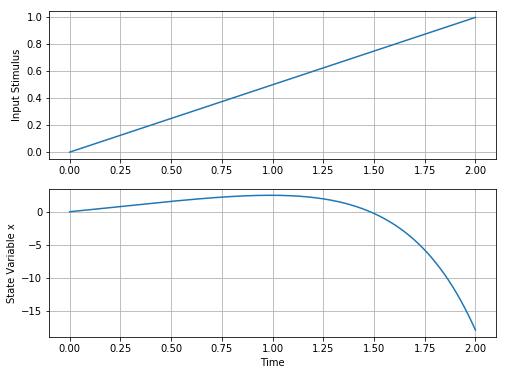

In [5]:
fig, axes = plt.subplots(2,1,figsize=(8,6))
axes[0].plot(t,stimulus); axes[0].set_ylabel('Input Stimulus')
axes[1].plot(t,x); axes[1].set_ylabel('State Variable x')
for ax in axes:
    ax.grid('on')
axes[1].set_xlabel('Time');

### Grid Search with Generated CUDA Kernel

We apply the grid search to find out the value for $a$ and $b$ used in the above simulation, given that $x^*$ trace is known. We extend the model definition with an intermediate variable `cost`, and a postprocessing function `post()`. The postprocessing function compute the running square error between the state variable `x` and $x^*$. 

In [6]:
def post(self, x_truth=0.):
    self.cost += (x_truth - self.x) **2

FOO.Default_Inters = {'cost': 0.}
FOO.post = post

We set up a grid of 1001-by-1001 points of $(a,b)$, uniformly distributed between $[2,4]\times[2,4]$.

In [7]:
arr = np.linspace(2, 4., 1001)
a_grid, b_grid = np.meshgrid(arr, arr)
num = a_grid.size

We then simulate $1001^2$ instances of the model, each of which is set up with a unique pair of $(a,b)$.

In [8]:
foo_grid = FOO()
foo_grid.cuda_prerun(dtype=dtype, num=num,
    stimulus=stimulus[0], x_truth=x[0],
    a=a_grid.flatten(), b=b_grid.flatten())

for i, (s,d) in enumerate(zip(stimulus, x)):
    foo_grid.cuda_update(dt, stimulus=s, x_truth=d)
cost = foo_grid.cost.get().reshape(a_grid.shape)

Finally, we find out the value of $(a, b)$ that has the lowest cost.

In [9]:
est_a = a_grid.flatten()[np.argmin(cost)]
est_b = b_grid.flatten()[np.argmin(cost)]

print "Parameter a - Ground Truth: %f, Estimated Value: %f" % (ran_a, est_a)
print "Parameter b - Ground Truth: %f, Estimated Value: %f" % (ran_b, est_b)

Parameter a - Ground Truth: 2.007837, Estimated Value: 2.008000
Parameter b - Ground Truth: 3.407913, Estimated Value: 3.408000
